___

# 1. Imports

In [1]:
import os
import gc
from glob import glob

import random
import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, precision_recall_fscore_support

import cv2
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm.notebook import tqdm
tqdm.pandas()

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.multiprocessing
import torch.nn.functional as F
from torch.cuda.amp import autocast
from torch.utils.data import Dataset, random_split
from torch.utils.data.dataloader import DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

In [3]:
test_path = "/storage/datasets/visione-artificiale/Warp-C/test_balanced/"

In [4]:
### Dataset params
num_workers = 8

img_width = 128
img_height = 128

mean_channel_1 = 0.337052
mean_channel_2 = 0.344904
mean_channel_3 = 0.351085
std_channel_1 = 0.180601
std_channel_2 = 0.176718
std_channel_3 = 0.183093

In [5]:
# Best model parameters
class params:
    batch_size = 1
    conv_units = 32
    dropout_rate = 0.0
    learning_rate = 0.0001
    weight_decay = 0.01

In [6]:
torch.manual_seed(42)
torch.set_grad_enabled(True)
torch.backends.cudnn.benchmark = True
torch.multiprocessing.set_sharing_strategy("file_system")

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

___

# 2. Load dataset

In [8]:
base_transform = transforms.Compose([
    # Resize image
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),

    # Color normalization
    transforms.Normalize(
        mean=(mean_channel_1, mean_channel_2, mean_channel_3),
        std=(std_channel_1, std_channel_2, std_channel_3)
    )
])

In [9]:
# Extending ImageFolder to get images paths
class ImageFolderWithFilename(ImageFolder):
    def __getitem__(self, index):
        original_tuple = super().__getitem__(index)
        path = self.imgs[index][0]
        #filename = os.path.basename(path)
        return (*original_tuple, path)

# Load the test dataset
test_dataset = ImageFolderWithFilename(root=test_path, transform=base_transform)

___

# 3. Dataset info

In [10]:
class_labels = test_dataset.classes
num_classes = len(class_labels)
print(f"Dataset loaded with {num_classes} classes")
print("Classes:", *class_labels, sep=", ", end="\n\n")

# print(f"Training images: {len(train_dataset.imgs)}")
print(f"Test images: {len(test_dataset.imgs)}")

Dataset loaded with 28 classes
Classes:, bottle-blue, bottle-blue-full, bottle-blue5l, bottle-blue5l-full, bottle-dark, bottle-dark-full, bottle-green, bottle-green-full, bottle-milk, bottle-milk-full, bottle-multicolor, bottle-multicolorv-full, bottle-oil, bottle-oil-full, bottle-transp, bottle-transp-full, bottle-yogurt, canister, cans, detergent-box, detergent-color, detergent-transparent, detergent-white, glass-dark, glass-green, glass-transp, juice-cardboard, milk-cardboard

Test images: 1551


In [11]:
# Create data loaders for batching
test_loader = DataLoader(test_dataset, batch_size=params.batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

for (images, labels, _) in tqdm(test_loader, desc="Test to GPU"):
    images, labels = images.to(device), labels.to(device)

Test to GPU:   0%|          | 0/1551 [00:00<?, ?it/s]

___

# 4. Load Model

In [12]:
class CNN(nn.Module):
    def __init__(self, conv_units=None, learning_rate=None, weight_decay=None, dropout_rate=None, batch_size=None):
        super().__init__()
        self.name = f"CNN_{img_width}x{img_height}_{batch_size}bs_{learning_rate}lr_{weight_decay}wd_{conv_units}conv_{dropout_rate}dr"

        units = conv_units
        self.features_conv = nn.Sequential(
            nn.Conv2d(3, units, kernel_size=3, padding=1),
            nn.BatchNorm2d(units),
            nn.ReLU(),
            nn.Conv2d(units, units*2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(units*2),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(units*2, units*4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(units*4),
            nn.ReLU(),
            nn.Conv2d(units*4, units*4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(units*4),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(units*4, units*8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(units*8),
            nn.ReLU(),
            nn.Conv2d(units*8, units*8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(units*8),
            nn.ReLU()
        )

        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        
        self.classifier = nn.Sequential(            
            nn.Flatten(),
            nn.Linear(conv_units * 8 * (img_width // 8) * (img_height // 8), 1024),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

        self.gradients = None
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    def activations_hook(self, grad):
        self.gradients = grad
    
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.features_conv(x)

    def forward(self, x, register_hook=False):
        x = self.features_conv(x)
        if register_hook:
            h = x.register_hook(self.activations_hook)
        x = self.max_pool(x)
        x = self.classifier(x)
        return x

In [13]:
model = CNN(conv_units=params.conv_units, learning_rate=params.learning_rate, weight_decay=params.weight_decay, dropout_rate=params.dropout_rate, batch_size=params.batch_size)

model_path = f"models/HT/CNN_128x128_16bs_0.0001lr_0.01wd_32conv_0.0dr.pt"
model = torch.load(model_path)
model = model.to(device)
model

CNN(
  (features_conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), paddin

In [14]:
@torch.no_grad()
def predict(model, data_loader):
    # Validation loop
    model.eval() # Set the model to evaluation mode

    res_predictions, res_labels, res_paths, res_kpreds = [], [], [], []
    for (images, labels, paths) in tqdm(data_loader, desc="Validating model", leave=False):
        images.requires_grad = True
        images, labels = images.to(device), labels
        outputs = model(images)

        _, k_preds = outputs.topk(15)
        _, predictions = torch.max(outputs, dim=1)
        
        res_predictions.extend(predictions.cpu().numpy())
        res_labels.extend(labels.cpu().numpy())
        res_paths.extend(paths)
        res_kpreds.extend(k_preds.cpu().numpy())

    res_df = pd.DataFrame({
        "filename": res_paths,
        "label": res_labels,
        "predicted": res_predictions,
        "k_predicted": res_kpreds
    })
    return res_df

___

# 5. Model Performance on TestSet

In [15]:
df = predict(model, test_loader)

print(df.shape)
df.head()

Validating model:   0%|          | 0/1551 [00:00<?, ?it/s]

(1551, 4)


,filename,label,predicted,k_predicted
0,/storage/datasets/visione-artificiale/Warp-C/t...,0,0,"[0, 2, 12, 14, 3, 1, 6, 15, 13, 21, 25, 10, 7,..."
1,/storage/datasets/visione-artificiale/Warp-C/t...,0,14,"[14, 12, 0, 4, 21, 2, 6, 8, 13, 10, 25, 20, 15..."
2,/storage/datasets/visione-artificiale/Warp-C/t...,0,8,"[8, 14, 22, 27, 0, 6, 2, 12, 21, 10, 17, 20, 2..."
3,/storage/datasets/visione-artificiale/Warp-C/t...,0,14,"[14, 21, 0, 12, 8, 2, 6, 15, 4, 25, 20, 13, 22..."
4,/storage/datasets/visione-artificiale/Warp-C/t...,0,2,"[2, 0, 6, 12, 14, 10, 3, 21, 4, 20, 7, 8, 13, ..."


### 5.1 Results @1

                         precision    recall  f1-score   support

            bottle-blue       0.55      0.68      0.61       104
       bottle-blue-full       0.62      0.37      0.46        43
          bottle-blue5l       0.67      0.64      0.65        72
     bottle-blue5l-full       0.78      0.29      0.42        24
            bottle-dark       0.67      0.94      0.78        95
       bottle-dark-full       0.76      0.56      0.64        34
           bottle-green       0.64      0.78      0.71        74
      bottle-green-full       0.92      0.65      0.76        34
            bottle-milk       0.39      0.42      0.41        57
       bottle-milk-full       0.82      0.43      0.56        21
      bottle-multicolor       0.60      0.32      0.42        28
bottle-multicolorv-full       0.70      0.67      0.68        21
             bottle-oil       0.34      0.50      0.40        48
        bottle-oil-full       0.00      0.00      0.00         8
          bottle-transp 

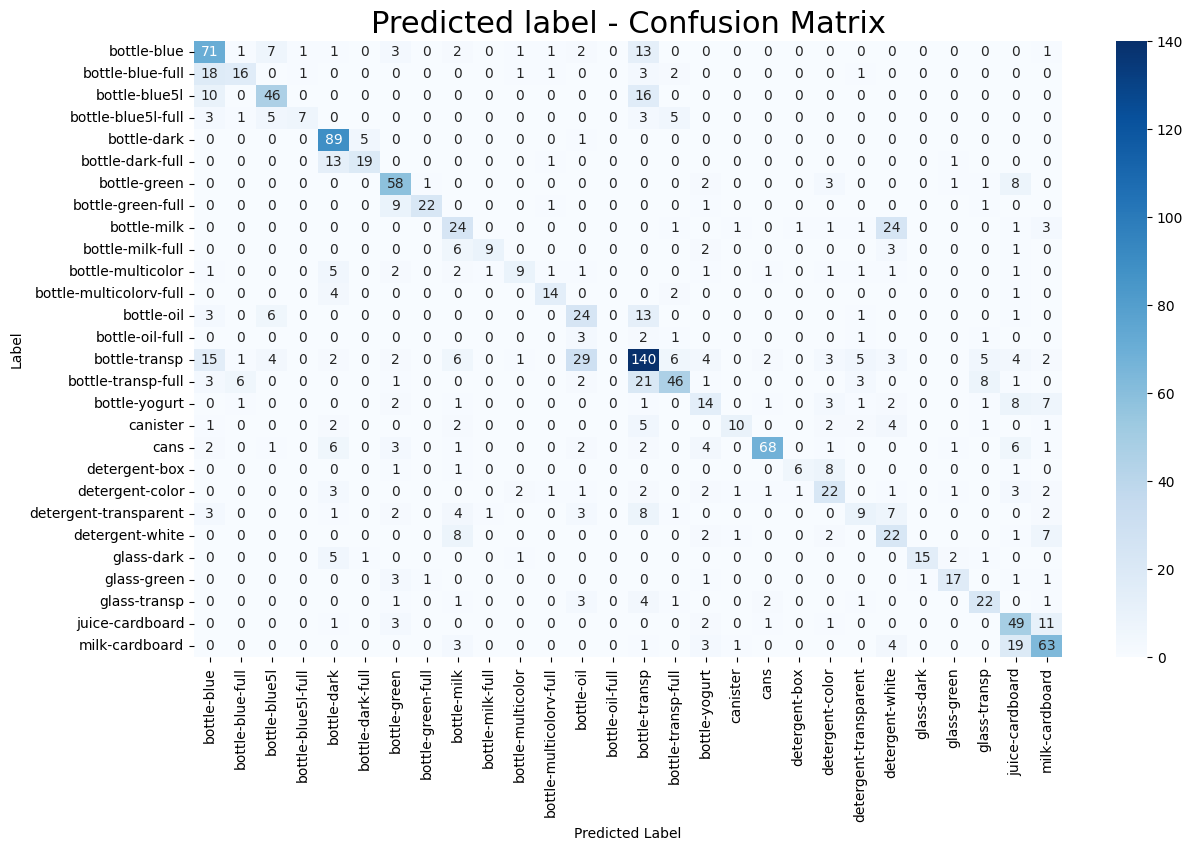

In [16]:
print(classification_report(df.label, df.predicted, target_names=class_labels, zero_division=0))
cm = confusion_matrix(df.label, df.predicted)

plt.figure(figsize=(14,8))
plt.title("Predicted label - Confusion Matrix", fontsize=22);
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels);
plt.xlabel("Predicted Label")
plt.ylabel("Label")
plt.show()

### 5.1.1 Results @1 - Parent class

              precision    recall  f1-score   support

      bottle       0.89      0.88      0.89      1031
    canister       0.71      0.33      0.45        30
        cans       0.89      0.69      0.78        98
   detergent       0.51      0.54      0.53       144
       glass       0.72      0.67      0.70        86
       juice       0.46      0.72      0.56        68
        milk       0.62      0.67      0.64        94

    accuracy                           0.80      1551
   macro avg       0.69      0.65      0.65      1551
weighted avg       0.81      0.80      0.80      1551



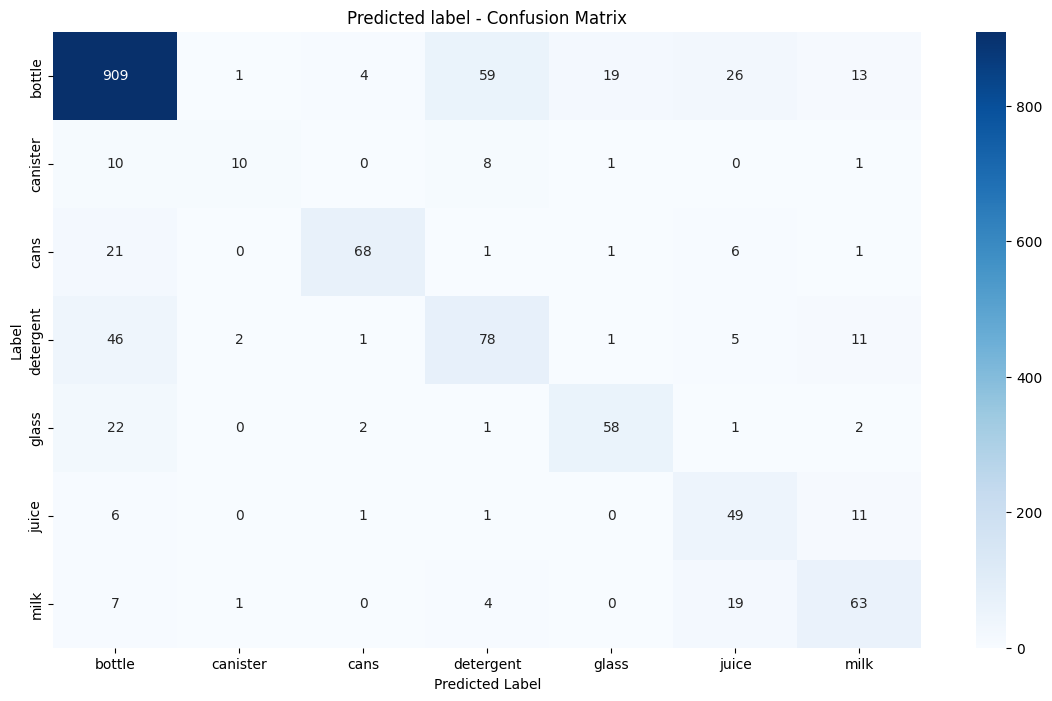

In [38]:
parent_labels = [class_labels[c].split("-")[0] for c in df.label]
parent_class_map = dict(enumerate(sorted(set(parent_labels))))
parent_labels_predictions = [class_labels[c].split("-")[0] for c in df.predicted]

print(classification_report(parent_labels, parent_labels_predictions, zero_division=0))
cm = confusion_matrix(parent_labels, parent_labels_predictions)

plt.figure(figsize=(14,8))
plt.title("Predicted label - Confusion Matrix")
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=parent_class_map.values(), yticklabels=parent_class_map.values());
plt.xlabel("Predicted Label")
plt.ylabel("Label")
plt.show()

### 5.3 Results @k

F1-score @top-k


,k,f1
0,1,0.587363
1,2,0.792392
2,3,0.859446
3,4,0.901354
4,5,0.932946
5,6,0.949710
6,7,0.960671
7,8,0.967118
8,9,0.974210
9,10,0.976144


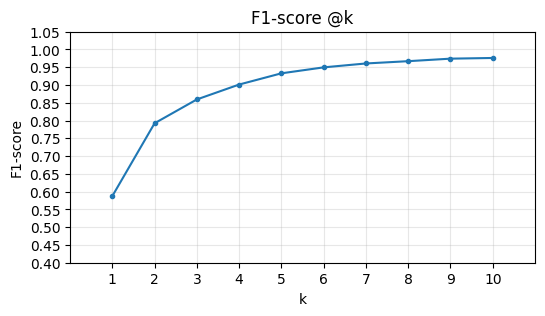

In [17]:
max_k = 10+1
prf_k = []
for k in range(1, max_k):
    df["top_k"] = df.apply(lambda r: r.label if r.label in r.k_predicted[:k] else (r.label+1)%len(class_labels), axis=1)
    _, _, f1, _ = precision_recall_fscore_support(df.label, df.top_k, average="micro")
    prf_k.append({"k": k, "f1": f1})

prf_k = pd.DataFrame(prf_k)

print("F1-score @top-k")
display(prf_k)

plt.figure(figsize=(6, 3))
plt.title("F1-score @k")
plt.plot(prf_k.k, prf_k.f1, ".-")
plt.xlabel("k")
plt.ylabel("F1-score")
plt.xlim(0, max_k)
plt.xticks(np.arange(1, max_k))
plt.yticks(np.arange(.4, 1.1, .05))
plt.grid(alpha=.3)
plt.show()

                         precision    recall  f1-score   support

            bottle-blue       0.99      0.95      0.97       104
       bottle-blue-full       0.88      0.84      0.86        43
          bottle-blue5l       0.91      0.97      0.94        72
     bottle-blue5l-full       0.92      0.96      0.94        24
            bottle-dark       0.99      0.99      0.99        95
       bottle-dark-full       0.97      0.97      0.97        34
           bottle-green       0.99      0.97      0.98        74
      bottle-green-full       0.94      0.97      0.96        34
            bottle-milk       0.98      0.96      0.97        57
       bottle-milk-full       0.90      0.90      0.90        21
      bottle-multicolor       0.92      0.82      0.87        28
bottle-multicolorv-full       0.78      0.86      0.82        21
             bottle-oil       0.93      0.90      0.91        48
        bottle-oil-full       0.44      0.50      0.47         8
          bottle-transp 

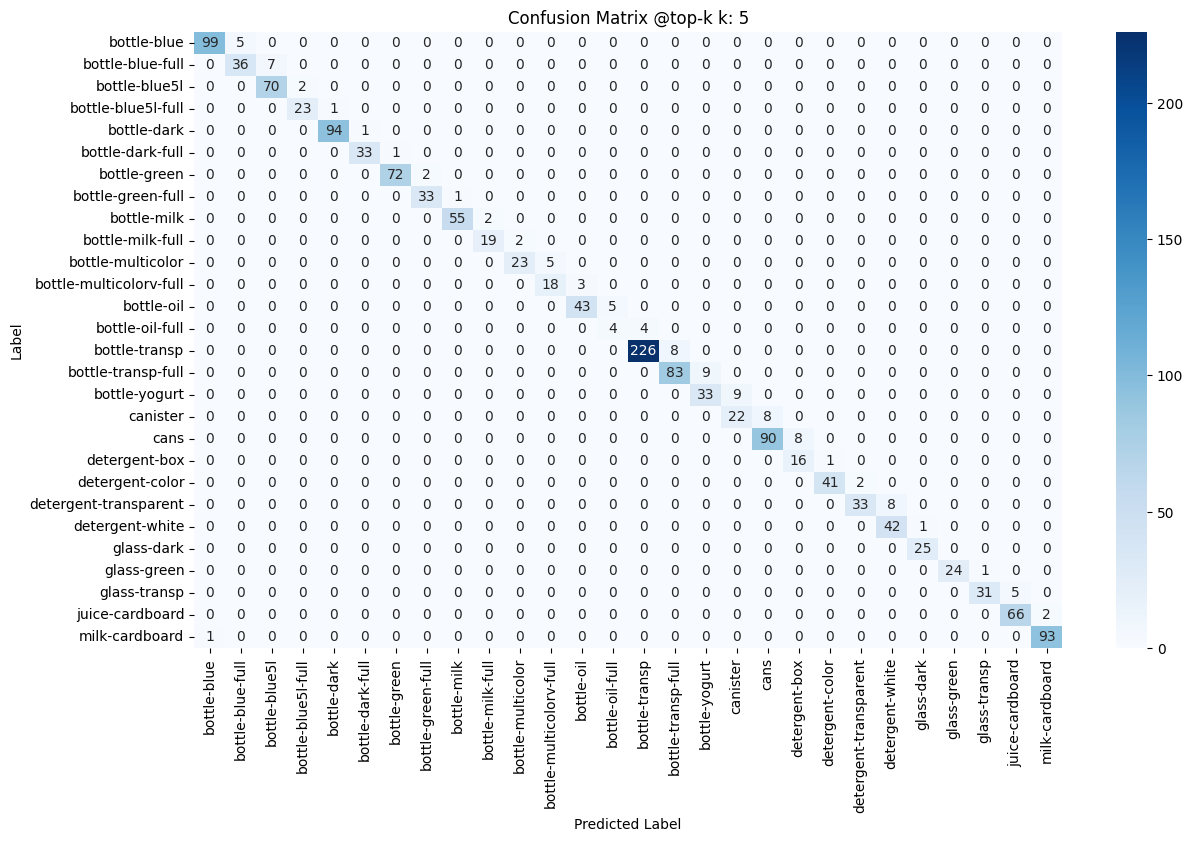

In [18]:
### We choose 5 as the elbow point for k
k_predictions = 5
df["top_k"] = df.apply(lambda r: r.label if r.label in r.k_predicted[:k_predictions] else (r.label+1)%len(class_labels), axis=1)

print(classification_report(df.label, df.top_k, target_names=class_labels, zero_division=0))
cm = confusion_matrix(df.label, df.top_k)

plt.figure(figsize=(14,8))
plt.title(f"Confusion Matrix @top-k k: {k_predictions}");
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels);
plt.xlabel("Predicted Label")
plt.ylabel("Label");

___

# 6. GradCAM

In [19]:
def evaluate_gradcam(image, label, path):
    pred = model(image, register_hook=True)
    # label_pred = pred.argmax(dim=1)
    labels_pred = pred.topk(5)
    pred.sum().backward()
    
    gradients = model.get_activations_gradient()
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    activations = model.get_activations(image).detach()
    
    for i in range(64):
        activations[:, i, :, :] *= pooled_gradients[i]
    
    heatmap_act = torch.mean(activations, dim=1).squeeze()
    heatmap_act = np.maximum(heatmap_act.cpu(), 0)
    heatmap_act /= torch.max(heatmap_act)
    
    image_rgb = cv2.imread(path)
    
    heatmap = cv2.resize(heatmap_act.numpy(), (image_rgb.shape[1], image_rgb.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    superimposed_img = heatmap * 0.5 + image_rgb
    superimposed_img = np.uint8(superimposed_img)
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
    return image_rgb, heatmap_act, superimposed_img, labels_pred

### 6.1 Visualize some GradCam output

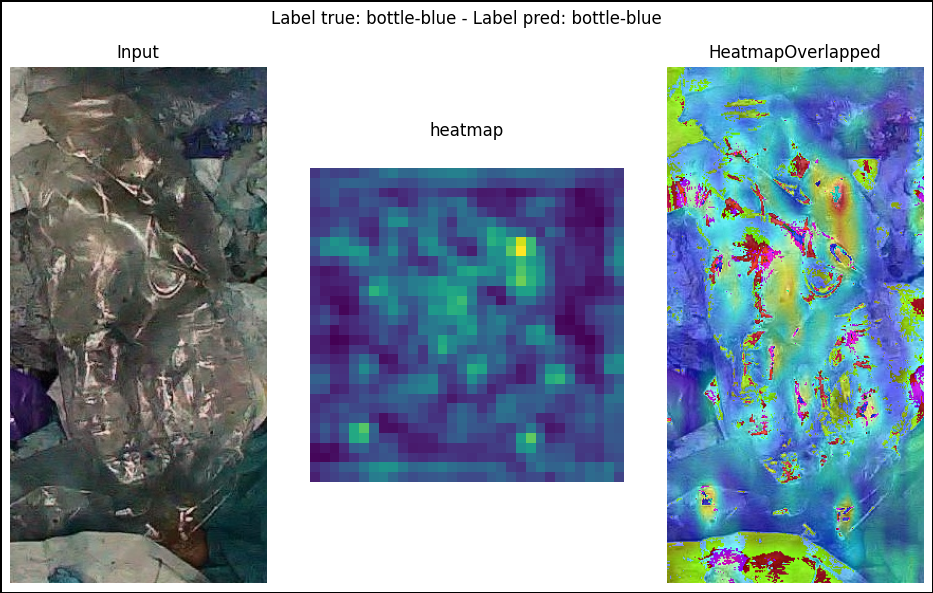

In [20]:
nth = 0
for image, label, path in test_loader:
    image, label, path = image[0], label[0], path[0]
    image = image.unsqueeze(0).to(device)
    image.requires_grad = True
    
    image_rgb, heatmap_act, superimposed_img, labels_pred = evaluate_gradcam(image, label, path)
    label_pred = labels_pred[1][0][0]
    
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 6))
    fig.suptitle(f"Label true: {class_labels[label]} - Label pred: {class_labels[label_pred]}")
    
    border_color = 'black'
    border_width = 2
    fig.patch.set_edgecolor(border_color)
    fig.patch.set_linewidth(border_width)
    
    axs[0].set_title("Input")
    axs[0].imshow(image_rgb)
    
    axs[1].set_title("heatmap")
    axs[1].matshow(heatmap_act.squeeze())
    
    axs[2].set_title("HeatmapOverlapped")
    axs[2].imshow(superimposed_img)
    
    [ax.axis("off") for ax in axs]
    plt.tight_layout()
    plt.show()
    
    nth += 1
    if nth == 1: break

### 6.2 Export GradCam outputs

In [21]:
!mkdir -p grad_cam_activations/correct grad_cam_activations/incorrect

In [22]:
for nth, (image, label, path) in tqdm(enumerate(test_loader), total=len(test_loader.dataset.imgs)):
    # Getting first entry because the batch size is 1 during prediction-only
    image, label, path = image[0], label[0], path[0]
    image = image.unsqueeze(0).to(device)
    image.requires_grad = True

    image_rgb, heatmap_act, superimposed_img, labels_pred = evaluate_gradcam(image, label, path)
    label_pred = labels_pred[1][0][0]
    pred_classes = list(zip(labels_pred[1][0].detach().cpu().numpy(), F.softmax(labels_pred[0], dim=1).squeeze().tolist()))
    pred_classes = [(class_labels[c], np.round(s, 3)) for c,s in pred_classes]
    
    ### Plot and save GradCam
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(12, 6), dpi=400) #, sharex=True)
    fig.suptitle(f"\nTrue label: {class_labels[label]} - Predicted: {class_labels[label_pred]}\n")
    fig.patch.set_edgecolor("black")
    fig.patch.set_linewidth(2)
    
    table = ax1.table(cellText=pred_classes, colWidths=[0.5, 0.3], colLabels=["Class predicted", "Score"], loc="upper left", bbox=[0, .5, .9, .3])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    ax1.add_table(table)
    ax1.axis("off")
    
    ax2.imshow(image_rgb)
    ax2.axis("off")
    
    ax3.matshow(heatmap_act.squeeze())
    ax3.axis("off")
    
    ax4.imshow(superimposed_img)
    ax4.axis("off")
    
    # Save the entire figure with all the plots
    prediction_result = "correct" if class_labels[label] == class_labels[label_pred] else "incorrect"
    output_path = f"grad_cam_activations/{prediction_result}/{nth}_{os.path.basename(path)}"
    
    # plt.show()
    plt.tight_layout()
    plt.savefig(output_path)
    plt.figure().clear()
    plt.close()
    plt.cla()
    plt.clf()
    plt.close('all')
    gc.collect()
    plt.ioff()
    # break

  0%|          | 0/1551 [00:00<?, ?it/s]